# Lista 1

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

## Questão 1

Vamos buscar pares cointegrados, candidatos a uma estratégia de pairs trading (arbitragem estatística). O teste de Engle-Granger é uma forma de encontrar estes pares. Dadas duas séries temporais X e Y, os passos são os seguintes:

1. Verifique que ambas as séries são I(1).

2. Encontre os coeficientes α e β da regressão linear. `Y = α + βX + ε`

3. Calcule a série temporal de resíduos ε e verifique se ela é I(0). Caso sim, as séries são cointegradas. 

Utilize as séries de preços diários entre o primeiro dia de 2018 e o primeiro dia de 2020. Encontre 3 pares cointegrados com o ativo PETR3 e indique a equação de regressão nestes casos. Plote também os gráficos dos resíduos, incluindo uma linha horizontal com a média dos mesmos. Através de inspeção visual dos mesmos, você acha que uma estratégia de pairs trading nestes pares neste período teria trazido lucro?

In [2]:
# filtra dados
data = pd.read_csv("data/IBOV.csv")
data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d")
data = data.set_index("Date")

df2018 = data[data.index.year == 2018]
df2019 = data[data.index.year == 2019]

data = df2018.append(df2019)

# separa PETR3
petr3 = data["PETR3"]
petr3 = petr3.values.reshape(-1, 1)
if "PETR3" in data:
    del data["PETR3"]

# remove IBOV da lista
if "IBOV" in data:
    del data["IBOV"]
    

data.head()

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,75.10,20.47,27.15,19.70,21.19,29.57,22.35,11.51,20.15,21.59,...,28.17,8.09,17.51,18.50,17.01,12.40,9.85,9.31,39.06,18.49
2018-01-03,75.30,20.51,27.06,19.54,21.55,29.95,22.36,11.47,20.24,21.69,...,27.94,8.39,18.00,18.36,17.04,12.41,10.06,9.62,38.83,18.21
2018-01-04,76.00,20.40,27.23,20.08,21.69,30.24,22.41,11.61,20.61,22.04,...,28.28,8.65,18.05,18.41,16.77,12.35,10.00,10.17,38.99,18.03
2018-01-05,76.44,20.48,27.20,19.70,22.00,30.24,22.56,11.65,20.61,22.17,...,28.58,8.85,18.10,18.36,16.85,12.46,10.21,9.73,39.59,18.10
2018-01-08,76.76,20.44,26.91,19.54,22.10,30.31,22.69,11.60,20.61,22.16,...,29.08,9.28,17.84,18.80,16.77,12.29,10.21,9.84,40.47,18.25


In [3]:
# filtra apenas séries não estacionárias

stationary = []

for col in data:
    r = adfuller(data[col])
    # filtra p-value com threashold de 0.05
    if r[1] < 0.05:
        stationary.append(col)
        
# remove séries estacionárias
for col in data:
    if col in stationary:
        del data[col]
        
print(f"Séries estacionárias (removidas): {stationary}")
print(f"Séries não estacionárias restantes: {len(data.columns)}")

Séries estacionárias (removidas): ['CIEL3', 'COGN3']
Séries não estacionárias restantes: 68


Ativo: BOVA11
Equação de regressão: Y = -5.788 + 0.362 * X + ε
Média: 4.4390905195560015e-15


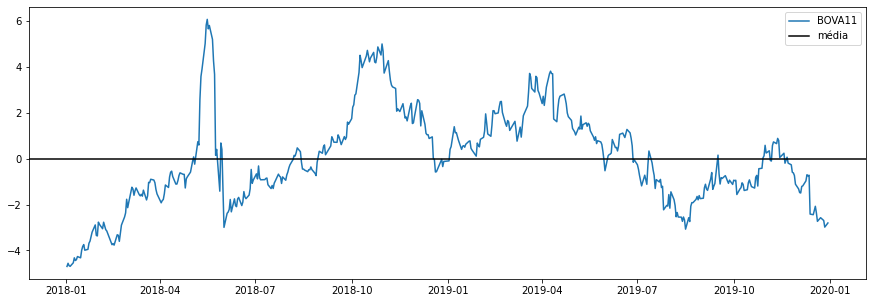

Ativo: AZUL4
Equação de regressão: Y = 14.363 + 0.318 * X + ε
Média: 4.266138940872001e-15


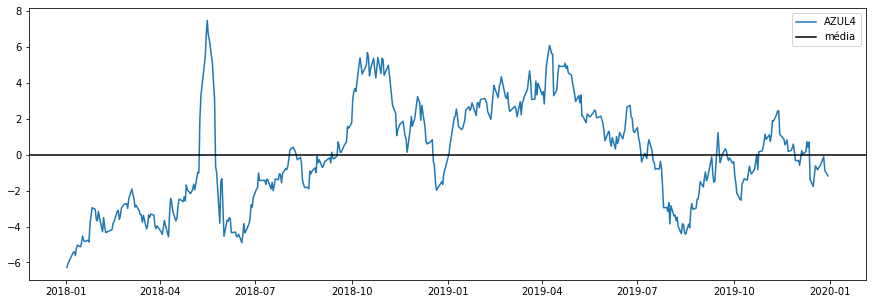

Ativo: B3SA3
Equação de regressão: Y = 14.937 + 0.367 * X + ε
Média: 4.496741045784001e-15


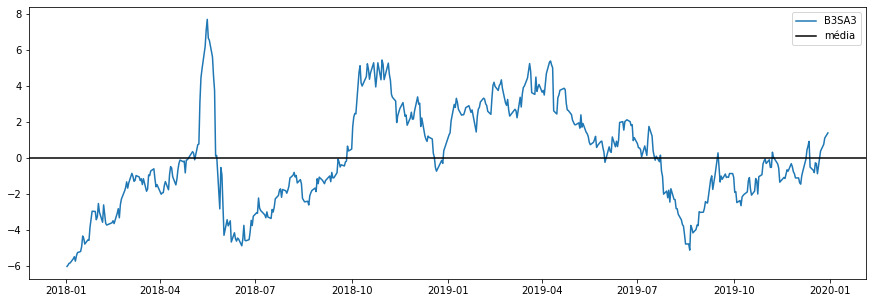

In [4]:
# calcula regressão linear entre PETR3 e outros stocks

MAX_RESULT = 3
result_count = 0

def find_residual(vpetr3, vstock, alpha, beta):
    return vpetr3 - alpha - beta * vstock

for col in data:
    if result_count >= MAX_RESULT:
        break
        
    series = data[col].values.reshape(-1, 1)
    model = LinearRegression().fit(series, petr3)

    alpha = model.intercept_[0]
    beta = model.coef_[0][0]

    # calcula série de resíduos
    residual = []
    for vpetr3, vstock in zip(petr3, series):
        vpetr3 = vpetr3[0]
        vstock = vstock[0]
    
        residual.append(find_residual(vpetr3, vstock, alpha, beta))
    
    # verifica se série é estacionária
    r = adfuller(residual)
    # filtra p-value com threashold de 0.05
    if r[1] < 0.05:
        print(f"Ativo: {col}")
        print(f"Equação de regressão: Y = {alpha:.3f} + {beta:.3f} * X + ε")
        print(f"Média: {np.array(residual).mean()}")
        plt.figure(figsize=(15,5))
        plt.plot(data.index, residual, label=col)
        plt.axhline(np.array(residual).mean(), color='black', label="média")
        plt.legend()
        plt.show()

        result_count += 1

## Questão 2

Nesta questão vamos simular o modelo de Markowitz com rebalanceamento diário e sem recálculo da estratégia. O universo de ativos será composto por todos os ativos disponibilizados (ativos do iBov + BOVA11). Utilize os dados do primeiro dia de 2019 até o primeiro dia de 2020 como in-sample e do primeiro dia de 2020 até o final como out-of-sample. Calcule o μ e Σ através dos dados históricos in-sample. Encontre:

In [5]:
# carrega dados
data = pd.read_csv("data/IBOV.csv")
data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d")
data = data.set_index("Date")

# remove IBOV
if "IBOV" in data:
    del data["IBOV"]
    
# separa dados já calculando os retornos
insample = data[data.index.year == 2019].pct_change().dropna()
outofsample = data[data.index.year == 2020].pct_change().dropna()
    
display(insample.head())
display(outofsample.head())

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.001138,0.010801,0.001101,0.010151,0.043413,0.004174,0.010940,0.006354,0.020850,0.010115,...,0.033004,0.011641,-0.026868,-0.042693,0.002741,-0.006029,0.023256,-0.022082,-0.040788,0.022753
2019-01-04,0.005682,0.013828,-0.003299,-0.033185,-0.036179,0.000000,-0.010020,-0.018942,-0.021965,-0.007942,...,-0.000933,0.046030,-0.045008,0.016689,0.039636,0.005199,0.027893,0.059140,0.064935,0.011680
2019-01-07,-0.000226,-0.004340,-0.026207,-0.044235,-0.005255,-0.006563,-0.014575,-0.006436,0.008668,0.011834,...,0.016573,0.002200,0.016238,-0.045748,-0.011394,0.032759,-0.022111,0.002030,-0.005311,-0.015943
2019-01-08,0.003956,-0.019925,-0.016431,0.046282,0.002642,-0.011231,-0.014790,0.001619,0.010937,0.006192,...,-0.007348,0.003293,0.022993,0.009870,-0.006206,0.037563,-0.040082,-0.028369,0.009690,-0.007821
2019-01-09,0.016774,0.013977,0.012385,0.066232,0.004893,-0.002895,-0.031693,0.016168,0.020866,0.017094,...,0.013879,0.007659,0.009524,0.059760,0.000000,0.012068,0.038544,0.033368,0.024285,0.010698


,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.003852,-0.014062,-0.034694,-0.013547,-0.028920,-0.001696,-0.011181,0.022503,-0.015336,0.000296,...,0.000000,-0.007498,0.040516,-0.003432,0.000334,0.001914,0.021304,-0.010406,-0.007362,-0.012575
2020-01-06,-0.010633,0.004754,-0.031008,-0.006242,-0.009539,-0.013215,0.016527,-0.006978,-0.005722,-0.017736,...,-0.025445,-0.024725,-0.006751,-0.001722,0.001000,-0.001274,-0.022989,-0.018927,-0.005934,0.002605
2020-01-07,-0.003109,0.002103,0.033091,-0.002356,0.032417,-0.007653,0.000570,0.016216,-0.017263,-0.017454,...,-0.006156,0.000000,-0.013437,0.012814,-0.008328,0.010842,0.004357,0.009646,0.007275,0.007794
2020-01-08,-0.002584,-0.004722,0.001760,0.013222,-0.002730,-0.009061,-0.000570,-0.029255,-0.015290,-0.015314,...,-0.009184,-0.001408,-0.003365,0.049878,-0.020155,0.010726,-0.013449,-0.012739,0.000185,-0.038098
2020-01-09,-0.002590,-0.007907,0.006325,0.053441,-0.000456,-0.020428,-0.002852,0.014247,-0.009580,-0.016174,...,-0.015952,-0.010578,0.025080,-0.002549,0.005142,-0.013733,0.016711,-0.006452,-0.013146,-0.014592


In [6]:
#calcula os retornos experados e a matriz de covariância
expected_returns = insample.mean()
display(expected_returns.head())

cov_matrix = insample.cov()
cov_matrix.head()

BOVA11    0.001016
ABEV3     0.000829
AZUL4     0.002175
BTOW3     0.002079
B3SA3     0.002076
dtype: float64

,BOVA11,ABEV3,AZUL4,BTOW3,B3SA3,BBAS3,BBSE3,BRML3,BBDC3,BBDC4,...,SANB11,CSNA3,SULA11,SUZB3,TAEE11,TIMP3,TOTS3,USIM5,VALE3,WEGE3
BOVA11,0.000126,0.000076,0.000145,0.000163,0.000168,0.000164,0.000082,0.000104,0.000147,0.000140,...,0.000137,0.000137,0.000050,0.000046,0.000073,0.000095,0.000037,0.000147,0.000133,0.000102
ABEV3,0.000076,0.000277,0.000118,0.000082,0.000120,0.000073,0.000064,0.000058,0.000080,0.000068,...,0.000086,0.000064,0.000042,0.000039,0.000046,0.000057,0.000019,0.000094,-0.000015,0.000089
AZUL4,0.000145,0.000118,0.000521,0.000231,0.000211,0.000214,0.000106,0.000157,0.000164,0.000149,...,0.000159,0.000149,0.000079,0.000035,0.000099,0.000109,0.000087,0.000206,0.000155,0.000125
BTOW3,0.000163,0.000082,0.000231,0.001004,0.000260,0.000193,0.000137,0.000217,0.000177,0.000160,...,0.000123,0.000159,0.000082,0.000027,0.000087,0.000083,0.000137,0.000214,0.000069,0.000151
B3SA3,0.000168,0.000120,0.000211,0.000260,0.000454,0.000215,0.000146,0.000167,0.000205,0.000184,...,0.000181,0.000115,0.000072,0.000056,0.000097,0.000136,0.000068,0.000137,0.000075,0.000169


**(a)** O portfolio de variância mínima global $p1$. Calcule $μ_{p1}$ e $σ_{p1}$, e plote um gráfico de barras com os pesos de todos os ativos i onde $wi ≥ 0.0001$ ou $wi≤−0.0001$.

/home/ing/.cache/pypoetry/virtualenvs/quantitative-finance-and-risk-management-YCOtMpuk-py3.8/lib/python3.8/site-packages/pypfopt/efficient_frontier.py:111: UserWarning: No expected returns provided. You may only use ef.min_volatility()
  warnings.warn(


Valor esperado: 0.01408450704225354
Variância: 0.0052403821803433375


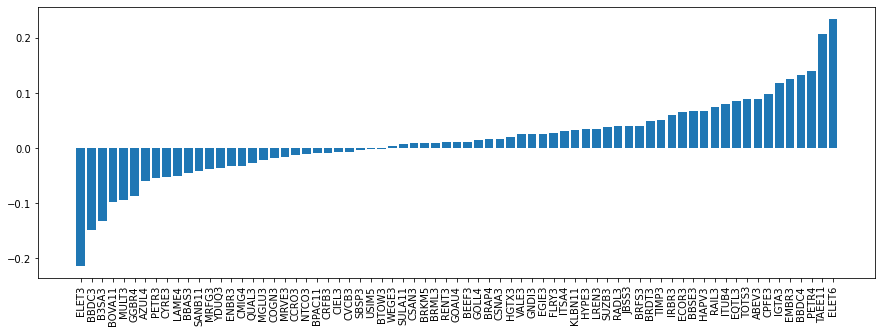

In [7]:
# instancia modelo
model = EfficientFrontier(
    expected_returns=None,
    cov_matrix=cov_matrix, 
    weight_bounds=(-1, 1), 
    verbose=False
)

# calcula variância mínima
weights = model.min_volatility()
weights_p1 = pd.Series(weights).sort_values()

print(f"Valor esperado: {weights_p1.mean()}")
print(f"Variância: {weights_p1.var()}")

# filtra ativos pelo peso
for stock, weight in weights_p1.items():
    if not (weight >= 0.0001 or weight <= -0.0001):
        if stock in weights_p1:
            del weights_p1[stock]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(weights_p1.index, weights_p1.values)
plt.show()

**(b)** O portfolio de variância mínima global, sem shorting, p2. Calcule $μ_{p2}$ e $σ_{p2}$, e plote um gráfico de barras com os pesos de todos os ativos i onde $wi≥0.0001$.

Valor esperado: 0.014084507042253521
Variância: 0.0009816266090160995


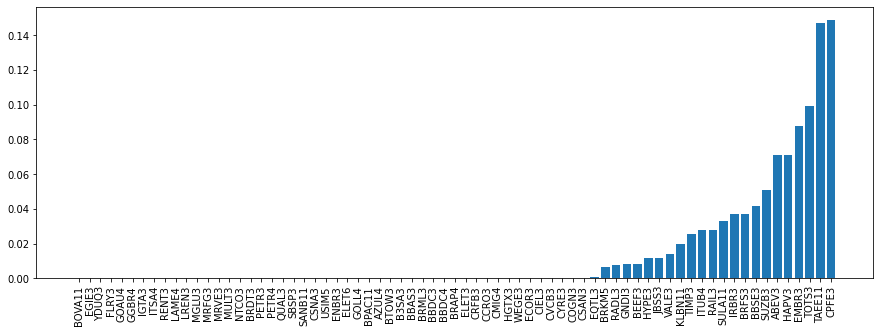

In [8]:
# instancia modelo
model = EfficientFrontier(
    expected_returns=None,
    cov_matrix=cov_matrix, 
    weight_bounds=(0.0001, 1), 
    verbose=False
)

# calcula variância mínima
weights = model.min_volatility()
weights_p2 = pd.Series(weights).sort_values()

print(f"Valor esperado: {weights_p2.mean()}")
print(f"Variância: {weights_p2.var()}")

# filtra ativos pelo peso
for stock, weight in weights_p2.items():
    if not weight >= 0.0001:
        if stock in weights_p2:
            del weights_p2[stock]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(weights_p2.index, weights_p2.values)
plt.show()

**(c)**  O portfolio eficiente sem shorting e com retorno esperado mínimo 0.3%, p3. Novamente, calcule $μ_{p3}$ e $σ_{p3}$ e plote um gráfico de barras com os pesos de todos os ativos i onde $wi≥0.0001$.

Valor esperado: 0.014084507042253521
Variância: 0.0009883982989737972


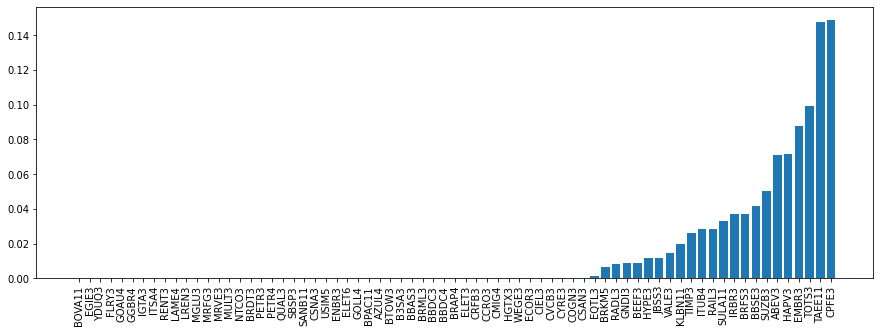

In [9]:
# instancia modelo
model = EfficientFrontier(
    expected_returns=expected_returns,
    cov_matrix=cov_matrix, 
    weight_bounds=(0, 1), 
    verbose=False
)

#adiciona restrição sobre retorno esperado
model.add_constraint(lambda w: sum(w) >= 0.003)

# calcula variância mínima
weights = model.min_volatility()
weights_p3 = pd.Series(weights).sort_values()

print(f"Valor esperado: {weights_p3.mean()}")
print(f"Variância: {weights_p3.var()}")

# filtra ativos pelo peso
for stock, weight in weights_p3.items():
    if not weight >= 0.0001:
        if stock in weights_p3:
            del weights[stock]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(weights_p3.index, weights_p3.values)
plt.show()

**(d)**  Calcule as séries out-of-sample dos três portfolios assumindo um investimento inicial de R$1. Plote um gráfico comparativo com a performance dos mesmos no período out-of-sample. Inclua também a série do índice iBov -  normalize o iBov para começar de 1.

**(e)**  Calcule o retorno médio e o desvio padrão diários das séries out-of-sample para cada portfolio. Estes valores estão condizentes com os valores calculados in-sample?

## Questão 3

No problema acima, suponha que você quisesse adicionar novas restrições:

**(a)** Nenhum ativo pode ter peso maior que 10% ou menor que -10%.

**(b)** Seja $W⊂N$ o conjunto de ativos que fazem parte do setor de teconologia. Você quer que seu portfolio tenha no máximo 30% em ações deste setor.

Escreva as restrições adicionais que você incluiria no seu modelo para garantir estas condições. Não é necessário resolver o modelo acima com estas restrições adicionais.

| | |
| :- | :- | 
|min | $\frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} w_i \cdot w_j \cdot σ_{ij}$ |
|sujeito a | $\sum_{i=1}^{N} w_i = 1$ |
| | $w_i < 0.1 \quad \forall i=1,\dots,N$ |
| | $w_i > -0.1 \quad \forall i=1,\dots,N$ |
| | $\sum_{w=1}^{W} w \leq 0.3 $ |